In [1]:
# Common imports
import pandas as pd
import numpy as np
import scipy as sp

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cm2 = ListedColormap(['#0000aa', '#ff2020'])
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import mglearn

在两个方面评估模型：
1. **交叉验证**：一种更可靠的评估泛化性能的方法
2. 评估分类和回归性能的方法：是在默认度量（`score`给出的精度和$R^2$）之外的方法。

**网格搜索**：一种调节监督模型参数以获得最佳泛化性能的有效方法。

## 5.1 交叉验证（cross-validation, CV）

CV的目的只是评估给定算法在特定数据集上训练后的泛化性能好坏。不是一种构建可应用于新数据的模型的方法，不会返回一个模型。

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [3]:
iris = load_iris()

In [4]:
iris.data.shape

(150, 4)

In [5]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [6]:
logistic_reg = LogisticRegression(random_state=42)

默认情况下，执行3折交叉验证（即`cv=3`），返回3个精度值:

In [8]:
cross_val_score(logistic_reg, iris.data, iris.target)  # default cv=3

array([ 0.96078431,  0.92156863,  0.95833333])

In [11]:
scores = cross_val_score(logistic_reg, iris.data, iris.target, cv=5)

In [12]:
print("CV score: {}".format(scores))

CV score: [ 1.          0.96666667  0.93333333  0.9         1.        ]


**总结CV精度的一种常用方法是计算平均值：**

In [13]:
print("Average cv score: {:.4f}".format(scores.mean()))

Average cv score: 0.9600


**折与折之间的精度有较大变化（90-100），这可能意味着模型强烈依赖于将某个折用于训练，但也可能是数据集的量太小。**

对数据进行多次划分，还可以提供模型的对训练集选择的敏感性信息。上述精度在90到100，它告诉我们将模型应用于新数据时在最坏情况和最好情况下的可能表现。

缺点：增加了计算成本。需要训练k个模型，所以交叉验证的速度比数据的单次划分大约慢k倍。

### 5.1 分层k折CV和其他交叉验证策略

从数据的前k分之一划分，可能并不好：

In [14]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Skl在**分类问题**中使用**分层K折交叉验证（stratified k-fold cross-validation）**。划分数据时使每个折中类别之间的比例与整个数据集中的比例相同。

在**回归问题**中默认使用标准k折交叉验证。

#### 5.1.1 对交叉验证的更多控制

允许提供一个**交叉验证分离器（cross-validation splitter）**作为`cv`参数，来对数据划分过程进行更精细的控制。

+ **k-fold**

`KFold`没有以'_'结尾的属性，只有`get_n_splits([X, y, groups])`和`split([X, y, groups])`方法。

In [44]:
from sklearn.model_selection import KFold

X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array(list("abcd"))

kfold = KFold(n_splits=2, random_state=42)
kfold

KFold(n_splits=2, random_state=42, shuffle=False)

In [45]:
# Returns the number of splitting iterations in the cross-validator
kfold.get_n_splits(X)

2

In [46]:
# Generate indices to split data into training and test set
train_indices, test_indices = kfold.split(X, y)   # 有y

In [47]:
for train_index, test_index in kfold.split(X):
    print("Train index: ", train_index, "Test index: ", test_index)

Train index:  [2 3] Test index:  [0 1]
Train index:  [0 1] Test index:  [2 3]


将`KFold`作为`cv`参数传入`cross_val_score`：

In [35]:
kfold = KFold(n_splits=5, random_state=42)

cross_val_score(logistic_reg, iris.data, iris.target, cv=kfold)

array([ 1.        ,  0.93333333,  0.43333333,  0.96666667,  0.43333333])

In [36]:
kfold = KFold(n_splits=3, random_state=42)

cross_val_score(logistic_reg, iris.data, iris.target, cv=kfold)

array([ 0.,  0.,  0.])

> 这样每一折对应一个类别，因此学不到任何东西。

另一种解决方法：将数据打乱来代替分层，以打乱样本按标签的排序。可以通过将`KFold`的`shuffle`参数设为`True`来实现这一点。

In [37]:
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

cross_val_score(logistic_reg, iris.data, iris.target, cv=kfold)

array([ 1.  ,  0.92,  1.  ])

#### 5.1.2 留一法交叉验证（LearveOneOut, LOO)

每折只包含一个样本的K折CV。每次划分，选择一个样本点作为测试集。对大型数据集来说非常耗时，但在小型数据集上有时可以给出更好的估计结果。

将`LeaveOneOut`作为`cv`参数传入`cross_val_score`：

In [38]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
scores = cross_val_score(logistic_reg, iris.data, iris.target, cv=loo)

print("Number of cv iterations: {}".format(len(scores)))
print("Mean accuracy: {:.4f}".format(scores.mean()))

Number of cv iterations: 150
Mean accuracy: 0.9533


In [40]:
loo.get_n_splits(iris.data)

150

#### 5.1.3 打乱划分交叉验证（ShufflSplit）

每次划分为训练集取样`train_size`个点，为测试集取样`test_size`个（不相交）点。将这一划分重复n_inter次。

`train_size`和`test_size`可以和不为1，允许每次迭代使用部分数据。

In [49]:
from sklearn.model_selection import ShuffleSplit

X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 1, 2])

shuffle_split = ShuffleSplit(n_splits=3, test_size=0.25, train_size=0.5,
                             random_state=42)
shuffle_split

ShuffleSplit(n_splits=3, random_state=42, test_size=0.25, train_size=0.5)

In [50]:
shuffle_split.get_n_splits()

3

In [51]:
for train_index, test_index in shuffle_split.split(X):
    print("Train index: ", train_index, "Test index: ", test_index)

Train index:  [3 0] Test index:  [1]
Train index:  [3 0] Test index:  [1]
Train index:  [0 1] Test index:  [3]


将`ShuffleSplit`作为`cv`参数传入`cross_val_score`：

In [52]:
shuffle_split = ShuffleSplit(n_splits=10, test_size=0.5, random_state=42)

cross_val_score(logistic_reg, iris.data, iris.target, cv=shuffle_split)

array([ 0.97333333,  0.94666667,  0.85333333,  0.92      ,  0.92      ,
        0.96      ,  0.89333333,  0.88      ,  0.94666667,  0.98666667])

#### 5.1.4 分组交叉验证

In [53]:
from sklearn.model_selection import GroupKFold
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=12, random_state=0)
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]

cross_val_score(logistic_reg, X, y, groups, cv=GroupKFold(n_splits=3))

array([ 0.75      ,  0.8       ,  0.66666667])

## 5.2 网格搜索

在尝试调参之前，重要的是要理解参数的含义。

**网格搜索（grid search）**：主要是尝试关心的参数的所有可能组合。

`GridSearchCV`常用的调参方法。

In [54]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100],
              "gamma": [0.001, 0.01, 0.1, 1, 10, 100]}

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

grid_serch = GridSearchCV(SVC(), param_grid=param_grid, cv=5, n_jobs=-1,
                          return_train_score=False)

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    random_state=0)

调用`fit`时，会对`param_grid`指定的每种参数组合都运行交叉验证：

In [69]:
grid_serch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

**拟合的`GridSearchCV`对象不仅会搜索最佳参数，还会利用得到最佳交叉验证性能的参数在整个训练集上自动拟合一个新模型。**

用`predict`和`score`方法来访问重新训练过的模型。

In [70]:
grid_serch.score(X_test, y_test)

0.97368421052631582

> 没有使用测试集来选择参数。

In [71]:
# 最佳模型
grid_serch.best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [72]:
# 最佳参数
grid_serch.best_params_

{'C': 100, 'gamma': 0.01}

`GridSearchCV`本身具有`predict`和`score`方法，可以不使用`best_estimator_`来进行预测或评估模型。

In [73]:
# 交叉验证最佳精度
grid_serch.best_score_

0.9732142857142857

#### 5.2.1 分析交叉验证结果

运行网格搜索的成本非常高，所以通常最好从相对比较稀疏且较小的网格开始搜索。然后检查结果，可能也会扩展搜索范围。

`grid_search.cv_results_`保存网格搜索的所有结果，是一个字典。

In [75]:
results = pd.DataFrame(grid_serch.cv_results_)
# 每一行对应一种特定的参数
display(results)  # 参数组合共36种

,mean_fit_time,mean_score_time,mean_test_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
0,0.012500,0.000598,0.366071,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",22,0.375000,0.347826,0.363636,0.363636,0.380952,2.246388e-03,0.000489,0.011371
1,0.009690,0.000602,0.366071,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",22,0.375000,0.347826,0.363636,0.363636,0.380952,7.282823e-03,0.000492,0.011371
2,0.000998,0.000599,0.366071,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",22,0.375000,0.347826,0.363636,0.363636,0.380952,2.336015e-07,0.000489,0.011371
3,0.000996,0.000800,0.366071,0.001,1,"{'C': 0.001, 'gamma': 1}",22,0.375000,0.347826,0.363636,0.363636,0.380952,2.219215e-06,0.000400,0.011371
4,0.001796,0.000599,0.366071,0.001,10,"{'C': 0.001, 'gamma': 10}",22,0.375000,0.347826,0.363636,0.363636,0.380952,7.468261e-04,0.000489,0.011371
5,0.001196,0.000399,0.366071,0.001,100,"{'C': 0.001, 'gamma': 100}",22,0.375000,0.347826,0.363636,0.363636,0.380952,3.990183e-04,0.000489,0.011371
6,0.000597,0.000198,0.366071,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",22,0.375000,0.347826,0.363636,0.363636,0.380952,4.871487e-04,0.000395,0.011371
7,0.000997,0.000598,0.366071,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",22,0.375000,0.347826,0.363636,0.363636,0.380952,3.234067e-07,0.000488,0.011371
8,0.000785,0.000594,0.366071,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",22,0.375000,0.347826,0.363636,0.363636,0.380952,3.927043e-04,0.000485,0.011371
9,0.000997,0.000600,0.366071,0.01,1,"{'C': 0.01, 'gamma': 1}",22,0.375000,0.347826,0.363636,0.363636,0.380952,2.986996e-06,0.000490,0.011371


> 每一行对应一种特定的参数设置。对于每种参数设置，交叉验证所有划分的结果都被记录下来，所欲划分的平均值和标准差也被记录下来。

搜索的二维参数网格，所以最适合**热图可视化**：

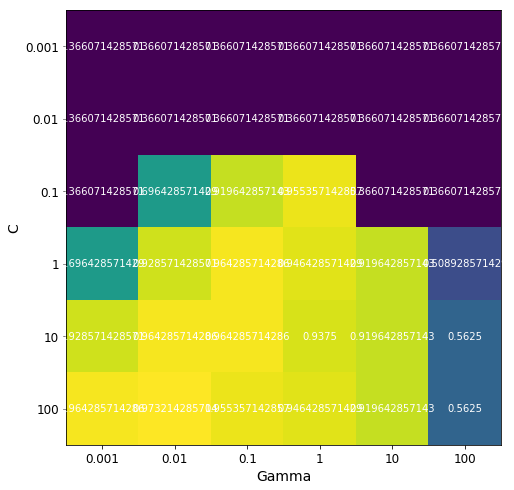

In [95]:
# 提取平均验证分数
scores = np.array(results["mean_test_score"]).reshape(6, 6)

plt.figure(figsize=(8, 8))
plt.imshow(scores, cmap=plt.cm.viridis)
plt.xlabel("Gamma")
plt.ylabel("C")
plt.xticks(np.arange(len(param_grid["gamma"])), param_grid["gamma"])
plt.yticks(np.arange(len(param_grid["C"])), param_grid["C"])

for i in range(len(param_grid["gamma"])):
    for j in range(len(param_grid["C"])):
        plt.text(j, i, scores[i, j], ha="center", va="center", color="w")
plt.show()